# CS 639 Problem set 1-2: Linear Classifiers (100 points)


Before we start, please put your name(s) and your UW NetID

1. Firstname1 LASTNAME1, NetID1   //   e.g.) Josef PIEPER, 0123456789
2. Firstname2 LASTNAME2, NetID2   //   e.g.) Mel GIBSON, 9876543210

**Your Answer:**   
1. Grant Ovsepyan,  ##########
2. Tiancheng Xiong, ##########

## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment, same as Assignment 1. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['linear_classifier.ipynb', 'cs639', 'knn.py', 'linear_classifier.py', 'ps1_helper.py', 'fully_connected_networks.ipynb', 'fully_connected_networks.py', 'knn.ipynb']
```

In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a CS_639 folder and put all the files under PS1 folder, then 'CS_639/PS1'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CS_639/PS1'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CS_639/PS1'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['cs639', '__pycache__', 'knn.py', 'ps1_helper.py', 'knn.ipynb', 'softmax_best_model.pt', 'linear_classifier.py', 'best_two_layer_net.pth', 'best_overfit_five_layer_net.pth', 'fully_connected_networks.py', 'tiancheng_ben_PS1.zip', 'fully_connected_networks.ipynb', 'linear_classifier.ipynb']


Once you have successfully mounted your Google Drive and located the path to this assignment, run th following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from linear_classifier.py!
```

as well as the last edit time for the file `linear_classifier.py`.

In [4]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Central"
time.tzset()

from linear_classifier import hello_linear_classifier
hello_linear_classifier()

linear_classifier_path = os.path.join(GOOGLE_DRIVE_PATH, 'linear_classifier.py')
linear_classifier_edit_time = time.ctime(os.path.getmtime(linear_classifier_path))
print('linear_classifier.py last edited on %s' % linear_classifier_edit_time)

Hello from linear_classifier.py!
linear_classifier.py last edited on Thu Feb 23 19:48:55 2023


# Data preprocessing

## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [5]:
import cs639
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics
import random
import time
import math
%matplotlib inline


plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

Starting in this assignment, we will use the GPU to accelerate our computation. Run this cell to make sure you are using a GPU.

In [6]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


## Load the CIFAR-10 dataset
Then, we will first load the CIFAR-10 dataset, same as knn. The utility function `cs639.data.preprocess_cifar10()` returns the entire CIFAR-10 dataset as a set of six **Torch tensors**:

- `X_train` contains all training images (real numbers in the range $[0, 1]$)
- `y_train` contains all training labels (integers in the range $[0, 9]$)
- `X_val` contains all validation images
- `y_val` contains all validation labels
- `X_test` contains all test images
- `y_test` contains all test labels

In this notebook we will use the **bias trick**: By adding an extra constant feature of ones to each image, we avoid the need to keep track of a bias vector; the bias will be encoded as the part of the weight matrix that interacts with the constant ones in the input.

In the `two_layer_net.ipynb` notebook that follows this one, we will not use the bias trick.

We can learn more about the `cs639.data.preprocess_cifar10` function by invoking the `help` command:

In [7]:
import cs639
help(cs639.data.preprocess_cifar10)

Help on function preprocess_cifar10 in module cs639.data:

preprocess_cifar10(cuda=True, show_examples=True, bias_trick=False, flatten=True, validation_ratio=0.2, dtype=torch.float32)
    Returns a preprocessed version of the CIFAR10 dataset, automatically
    downloading if necessary. We perform the following steps:
    
    (0) [Optional] Visualize some images from the dataset
    (1) Normalize the data by subtracting the mean
    (2) Reshape each image of shape (3, 32, 32) into a vector of shape (3072,)
    (3) [Optional] Bias trick: add an extra dimension of ones to the data
    (4) Carve out a validation set from the training set
    
    Inputs:
    - cuda: If true, move the entire dataset to the GPU
    - validation_ratio: Float in the range (0, 1) giving the fraction of the train
      set to reserve for validation
    - bias_trick: Boolean telling whether or not to apply the bias trick
    - show_examples: Boolean telling whether or not to visualize data samples
    - dtype: O

We can now run the `cs639.data.preprocess` function to get our data:

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .


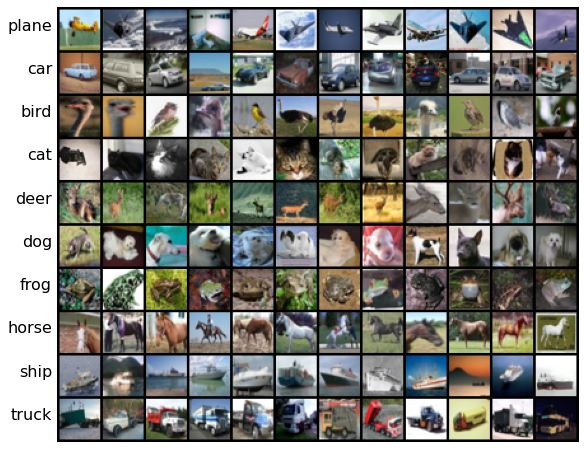

Train data shape:  torch.Size([40000, 3073])
Train labels shape:  torch.Size([40000])
Validation data shape:  torch.Size([10000, 3073])
Validation labels shape:  torch.Size([10000])
Test data shape:  torch.Size([10000, 3073])
Test labels shape:  torch.Size([10000])


In [8]:
# Invoke the above function to get our data. 
import cs639

cs639.reset_seed(0)
data_dict = cs639.data.preprocess_cifar10(bias_trick=True, cuda=True, dtype=torch.float64)
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

# Softmax Classifier

In this section, you will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

You SHOULD NOT use ".to()" or ".cuda()" in each implementation block.

First, let's start from implementing the naive softmax loss function with nested loops in `softmax_loss_naive` function. **(20 points)**

As a sanity check to see whether we have implemented the loss correctly, run the softmax classifier with a small random weight matrix and no regularization. You should see loss near log(10) = 2.3

In [9]:
import cs639
from linear_classifier import softmax_loss_naive

cs639.reset_seed(0)
# Generate a random softmax weight tensor and use it to compute the loss.
W = 0.0005 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

# YOUR_TURN: Complete the implementation of softmax_loss_naive and implement 
# a (naive) version of the gradient that uses nested loops.
loss, _ = softmax_loss_naive(W, X_batch, y_batch, reg=0.0)

# As a rough sanity check, our loss should be something close to log(10.0).
print('loss: %f' % loss)
print('sanity check: %f' % (math.log(10.0)))

loss: 2.303811
sanity check: 2.302585


Next, we use gradient checking to debug the analytic gradient of our naive softmax loss function. If you've implemented the gradient correctly, you should see relative errors less than `1e-5`.


In [10]:
import cs639
from linear_classifier import softmax_loss_naive

cs639.reset_seed(0)
W = 0.0005 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

# YOUR_TURN: Complete the implementation of softmax_loss_naive and implement 
# a (naive) version of the gradient that uses nested loops.
_, grad = softmax_loss_naive(W, X_batch, y_batch, reg=0.0)

f = lambda w: softmax_loss_naive(w, X_batch, y_batch, reg=0.0)[0]
cs639.grad.grad_check_sparse(f, W, grad, 10)

numerical: 0.003092 analytic: 0.003092, relative error: 4.237964e-07
numerical: 0.006273 analytic: 0.006273, relative error: 8.287629e-07
numerical: 0.005585 analytic: 0.005585, relative error: 8.451690e-07
numerical: 0.002617 analytic: 0.002617, relative error: 4.092661e-07
numerical: 0.007555 analytic: 0.007555, relative error: 1.919728e-07
numerical: 0.006469 analytic: 0.006469, relative error: 8.180338e-08
numerical: 0.011300 analytic: 0.011300, relative error: 6.389981e-09
numerical: 0.001744 analytic: 0.001744, relative error: 2.889650e-07
numerical: -0.014802 analytic: -0.014802, relative error: 8.577572e-08
numerical: -0.005098 analytic: -0.005098, relative error: 4.353266e-07


Let's perform another gradient check with regularization enabled. Again you should see relative errors less than `1e-5`.

In [11]:
import cs639
from linear_classifier import softmax_loss_naive

cs639.reset_seed(0)
W = 0.0005 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
reg = 5.0

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

# YOUR_TURN: Complete the gradient compuation part of softmax_loss_naive 
_, grad = softmax_loss_naive(W, X_batch, y_batch, reg)

f = lambda w: softmax_loss_naive(w, X_batch, y_batch, reg)[0]
cs639.grad.grad_check_sparse(f, W, grad, 10)

numerical: 0.005423 analytic: 0.005423, relative error: 1.499832e-07
numerical: 0.007710 analytic: 0.007710, relative error: 7.211370e-07
numerical: 0.009024 analytic: 0.009024, relative error: 5.033579e-07
numerical: 0.003147 analytic: 0.003147, relative error: 4.280010e-07
numerical: 0.005542 analytic: 0.005542, relative error: 1.662607e-07
numerical: 0.003248 analytic: 0.003248, relative error: 3.585442e-07
numerical: -0.001724 analytic: -0.001724, relative error: 1.735598e-07
numerical: -0.003267 analytic: -0.003267, relative error: 2.057893e-07
numerical: 0.006217 analytic: 0.006217, relative error: 2.294205e-07
numerical: -0.007518 analytic: -0.007518, relative error: 3.444910e-07


Then, let's move on to the vectorized form: `softmax_loss_vectorized`. **(20 points)**

Now that we have a naive implementation of the softmax loss function and its gradient, implement a vectorized version in softmax_loss_vectorized. The two versions should compute the same results, but the vectorized version should be much faster.

The differences between the naive and vectorized losses and gradients should both be less than `1e-6`, and your vectorized implementation should be at least 20x faster than the naive implementation.

In [12]:
import cs639
from linear_classifier import softmax_loss_naive, softmax_loss_vectorized

cs639.reset_seed(0)
W = 0.0005 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
reg = 0.1

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

# Run and time the naive version
torch.cuda.synchronize()
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('naive loss: %e computed in %fs' % (loss_naive, ms_naive))

# Run and time the vectorized version
# YOUR_TURN: Complete the implementation of softmax_loss_vectorized
torch.cuda.synchronize()
tic = time.time()
loss_vec, grad_vec = softmax_loss_vectorized(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('vectorized loss: %e computed in %fs' % (loss_vec, ms_vec))

# we use the Frobenius norm to compare the two versions of the gradient.
loss_diff = (loss_naive - loss_vec).abs().item()
grad_diff = torch.norm(grad_naive - grad_vec, p='fro')
print('Loss difference: %.2e' % loss_diff)
print('Gradient difference: %.2e' % grad_diff)
print('Speedup: %.2fX' % (ms_naive / ms_vec))

naive loss: 2.304580e+00 computed in 111.297369s
vectorized loss: 2.304580e+00 computed in 25.665045s
Loss difference: 8.88e-16
Gradient difference: 7.23e-16
Speedup: 4.34X


Let's check that your implementation of the softmax loss is numerically stable.

If either of the following print `nan` then you should double-check the numeric stability of your implementations. 

We will do this by using a well defined training pipeline. 

Please complete the implementation of `train_linear_classifier` in `linear_classifer.py`. **(5 points)**

In [13]:
import cs639
from linear_classifier import softmax_loss_naive, softmax_loss_vectorized, train_linear_classifier

cs639.reset_seed(0)
device = data_dict['X_train'].device
dtype = data_dict['X_train'].dtype
D = data_dict['X_train'].shape[1]
C = 10


W_ones = torch.ones(D, C, device=device, dtype=dtype)
W, loss_hist = train_linear_classifier(softmax_loss_naive, W_ones, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-7, reg=5.0e4,
                                       num_iters=1, verbose=True)


W_ones = torch.ones(D, C, device=device, dtype=dtype)
W, loss_hist = train_linear_classifier(softmax_loss_vectorized, W_ones, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-7, reg=5.0e4,
                                       num_iters=1, verbose=True)


iteration 0 / 1: loss 1536500002.302585
iteration 0 / 1: loss 1536500002.302585


Now lets train a softmax classifier with some default hyperparameters:



In [14]:
import cs639
from linear_classifier import softmax_loss_vectorized

cs639.reset_seed(0)

torch.cuda.synchronize()
tic = time.time()


W, loss_hist = train_linear_classifier(softmax_loss_vectorized, None, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-12, reg=1.2e4,
                                       num_iters=2000, verbose=True)

torch.cuda.synchronize()
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 2000: loss 2.302956
iteration 100 / 2000: loss 2.302954
iteration 200 / 2000: loss 2.302955
iteration 300 / 2000: loss 2.302954
iteration 400 / 2000: loss 2.302955
iteration 500 / 2000: loss 2.302955
iteration 600 / 2000: loss 2.302955
iteration 700 / 2000: loss 2.302955
iteration 800 / 2000: loss 2.302955
iteration 900 / 2000: loss 2.302955
iteration 1000 / 2000: loss 2.302955
iteration 1100 / 2000: loss 2.302957
iteration 1200 / 2000: loss 2.302957
iteration 1300 / 2000: loss 2.302955
iteration 1400 / 2000: loss 2.302956
iteration 1500 / 2000: loss 2.302954
iteration 1600 / 2000: loss 2.302956
iteration 1700 / 2000: loss 2.302955
iteration 1800 / 2000: loss 2.302957
iteration 1900 / 2000: loss 2.302956
That took 2.844981s


Plot the loss curve:

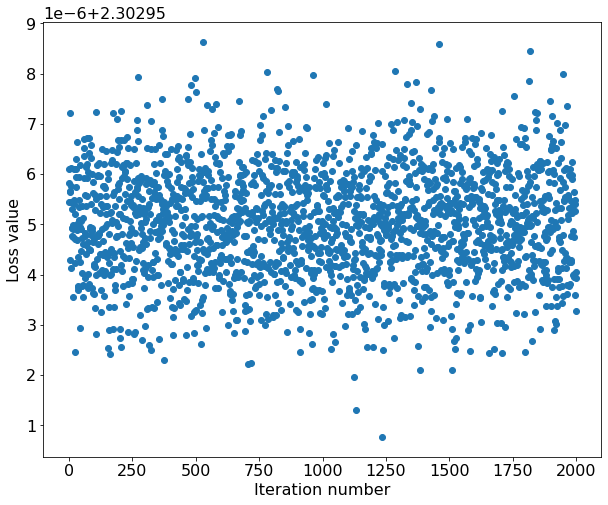

In [15]:
plt.plot(loss_hist, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

Let's compute the accuracy of current model. It should be less than 10%. To do that, complete the implementation of `predict_linear_classifier` in `linear_classifier.py`. **(15 points)**

In [16]:
import cs639
from linear_classifier import predict_linear_classifier

cs639.reset_seed(0)

# evaluate the performance on both the training and validation set

y_train_pred = predict_linear_classifier(W, data_dict['X_train'])
train_acc = 100.0 * (data_dict['y_train'] == y_train_pred).double().mean().item()
print('training accuracy: %.2f%%' % train_acc)
y_val_pred = predict_linear_classifier(W, data_dict['X_val'])
val_acc = 100.0 * (data_dict['y_val'] == y_val_pred).double().mean().item()
print('validation accuracy: %.2f%%' % val_acc)

training accuracy: 8.74%
validation accuracy: 8.39%


Now use the validation set to tune hyperparameters (regularization strength and learning rate). You should experiment with different ranges for the learning rates and regularization strengths.

Implement `softmax_get_search_params` and `test_one_param_set` in `linear_classifier.py` **(15 + 25 = 40 points)**

To get full credit for the assignment, your best model found through cross-validation should achieve an accuracy above 0.36 on the validation set.

(Our best model was above 40.1% -- did you beat us?)

In [17]:
import os
import cs639
from linear_classifier import Softmax, softmax_get_search_params, test_one_param_set

# YOUR_TURN: find the best learning_rates and regularization_strengths combination
#            in 'softmax_get_search_params'
learning_rates, regularization_strengths = softmax_get_search_params()
num_models = len(learning_rates) * len(regularization_strengths)


if num_models > 25:
  raise Exception("Please do not test/submit more than 25 items at once")
elif num_models < 5:
  raise Exception("Please present at least 5 parameter sets in your final ipynb")
####


i = 0
# As before, store your cross-validation results in this dictionary.
# The keys should be tuples of (learning_rate, regularization_strength) and
# the values should be tuples (train_acc, val_acc)
results = {}
best_val = -1.0   # The highest validation accuracy that we have seen so far.
best_softmax_model = None # The Softmax object that achieved the highest validation rate.
num_iters = 2000 # number of iterations

for lr in learning_rates:
  for reg in regularization_strengths:
    i += 1
    print('Training Softmax %d / %d with learning_rate=%e and reg=%e'
          % (i, num_models, lr, reg))
    
    cs639.reset_seed(0)
    cand_softmax_model, cand_train_acc, cand_val_acc = test_one_param_set(Softmax(), data_dict, lr, reg, num_iters)

    if cand_val_acc > best_val:
      best_val = cand_val_acc
      best_softmax_model = cand_softmax_model # save the classifier
    results[(lr, reg)] = (cand_train_acc, cand_val_acc)


# Print out results.
for lr, reg in sorted(results):
  train_acc, val_acc = results[(lr, reg)]
  print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
         lr, reg, train_acc, val_acc))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

# save the best model
path = os.path.join(GOOGLE_DRIVE_PATH, 'softmax_best_model.pt')
best_softmax_model.save(path)

Training Softmax 1 / 16 with learning_rate=1.000000e-05 and reg=1.000000e-04
Training Softmax 2 / 16 with learning_rate=1.000000e-05 and reg=1.000000e-03
Training Softmax 3 / 16 with learning_rate=1.000000e-05 and reg=1.000000e-02
Training Softmax 4 / 16 with learning_rate=1.000000e-05 and reg=1.000000e-01
Training Softmax 5 / 16 with learning_rate=1.000000e-04 and reg=1.000000e-04
Training Softmax 6 / 16 with learning_rate=1.000000e-04 and reg=1.000000e-03
Training Softmax 7 / 16 with learning_rate=1.000000e-04 and reg=1.000000e-02
Training Softmax 8 / 16 with learning_rate=1.000000e-04 and reg=1.000000e-01
Training Softmax 9 / 16 with learning_rate=1.000000e-03 and reg=1.000000e-04
Training Softmax 10 / 16 with learning_rate=1.000000e-03 and reg=1.000000e-03
Training Softmax 11 / 16 with learning_rate=1.000000e-03 and reg=1.000000e-02
Training Softmax 12 / 16 with learning_rate=1.000000e-03 and reg=1.000000e-01
Training Softmax 13 / 16 with learning_rate=1.000000e-02 and reg=1.000000

Run the following to visualize your cross-validation results:

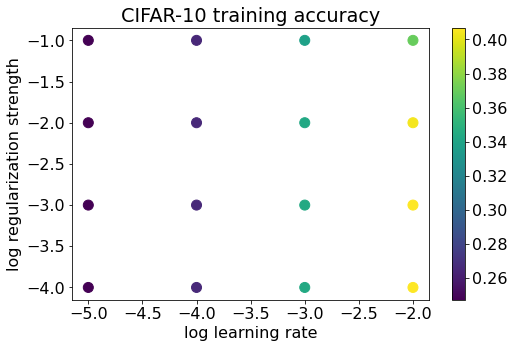

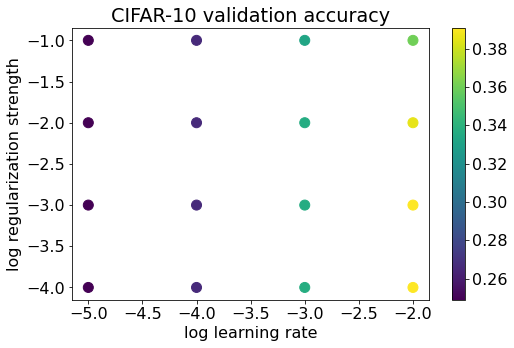

In [18]:
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

Then, evaluate the performance of your best model on test set. To get full credit for this assignment you should achieve a test-set accuracy above 0.35.

(Our best was just around 40.5% -- did you beat us?)



In [19]:
y_test_pred = best_softmax_model.predict(data_dict['X_test'])
test_accuracy = torch.mean((data_dict['y_test'] == y_test_pred).double())
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.395700


Finally, let's visualize the learned weights for each class

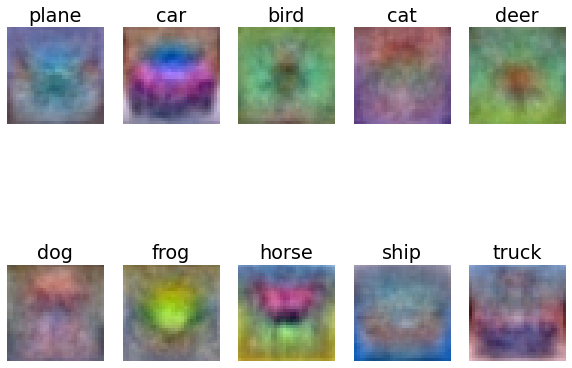

In [20]:
w = best_softmax_model.W[:-1,:] # strip out the bias
w = w.reshape(3, 32, 32, 10)
w = w.transpose(0, 2).transpose(1, 0)

w_min, w_max = torch.min(w), torch.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)

  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.type(torch.uint8).cpu())
  plt.axis('off')
  plt.title(classes[i])

Done! Now you can move to part 3 of the problem set, `fully_connected_networks.ipynb`. Remember to save both `linear_classifier.ipynb` and `linear_classifier.py` before exiting.